# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record



## Business Understanding
As a part of this project, we will try to implement a data driven approach to answer the following questions

1. What is the average income of Starbucks customers?
2. What is the average age of Starbucks customers?
3. What is the most common promotional offer and most common offer type?
4. How are the success rates for different promotional offers?
5. What are the most successful promotional offers among different age groups?
6. Who are the top 20 Starbuck loyal Customers?  

and 
#### Finally build a Supervised ML model to predict if a customer responds to a promotional offer!!

----------

## Data Understanding 

In [270]:
# importing necessary modules
import pandas as pd
import numpy as np
import math
import json
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [271]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [272]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
reward        10 non-null int64
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
offer_type    10 non-null object
id            10 non-null object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [273]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [274]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
gender              14825 non-null object
age                 17000 non-null int64
id                  17000 non-null object
became_member_on    17000 non-null int64
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [275]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [276]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
person    306534 non-null object
event     306534 non-null object
value     306534 non-null object
time      306534 non-null int64
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


------


## Data Preparation / Wrangling

### Portfolio

In [277]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [278]:
portfolio.isna().sum()

reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64

In [279]:
#extract all channel names
channel_list=set()

for channel in portfolio.channels:
    channel_list.update(channel)

channel_list

{'email', 'mobile', 'social', 'web'}

In [280]:
#append columns for channel names
for channel in channel_list:
    portfolio[channel]=[int (channel in x) for x in portfolio.channels]

portfolio

,reward,channels,difficulty,duration,offer_type,id,mobile,email,web,social
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,0,1
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,1,0
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,1,0
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837,1,1,0,1
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,1,0


In [281]:
#drop column channels
portfolio.drop('channels', inplace=True, axis=1)
portfolio

,reward,difficulty,duration,offer_type,id,mobile,email,web,social
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,0,1
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,1,0
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,1,0
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,1,1,0,1
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,1,0


In [282]:
#Adding offer_name column for easier each offer identification
portfolio['offer_name']=['offer_'+str(i) for i in range(1,portfolio.shape[0]+1)]
portfolio

,reward,difficulty,duration,offer_type,id,mobile,email,web,social,offer_name
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,0,1,offer_1
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,offer_2
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,1,0,offer_3
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0,offer_4
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,1,0,offer_5
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1,offer_6
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,offer_7
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,1,1,0,1,offer_8
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,offer_9
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,1,0,offer_10


### Profile

In [283]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [284]:
profile.shape

(17000, 5)

In [285]:
profile.isna().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

In [286]:
# imputing median for age, mean for income, mode for gender
profile.age.fillna(profile.age.median(), inplace=True)
profile.income.fillna(profile.income.mean(), inplace=True)
profile.gender.fillna(profile.gender.mode()[0], inplace=True)

In [287]:
profile.isna().sum()

gender              0
age                 0
id                  0
became_member_on    0
income              0
dtype: int64

### Transcript

In [288]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [289]:
transcript.shape

(306534, 4)

In [290]:
transcript.isna().sum()

person    0
event     0
value     0
time      0
dtype: int64

In [291]:
#finding different keys in value column
keys=set()

for val in transcript.value:
    keys.update(val.keys())

keys

{'amount', 'offer id', 'offer_id', 'reward'}

In [ ]:
#adding columns in transcript dataframe for keys 

## this cell will take lot of time as there are 306534 rows in transcript dataframe ###

transcript['amount']=0
transcript['offer_id']=''
transcript['reward']=0


for i in transcript.index:
    if(i%1000==0):
        print(i)
    val_dict=transcript.loc[i,'value']
    if('offer_id' in val_dict ):
        transcript.loc[i,'offer_id']=val_dict['offer_id']
    if('offer id' in val_dict ):
        transcript.loc[i,'offer_id']=val_dict['offer id']
    if('reward' in val_dict ):
        transcript.loc[i,'reward']=val_dict['reward']
    if('amount' in val_dict ):
        transcript.loc[i,'amount']=val_dict['amount']

transcript.drop('value',inplace=True,axis=1)

#writing the data to transcript.csv file
transcript.to_csv('transcript_clean.csv',index=False)

In [292]:
#read form transcript_clean.csv
transcript=pd.read_csv('transcript_clean.csv')
transcript.head()

,person,event,time,amount,offer_id,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0
2,e2127556f4f64592b11af22de27a7932,offer received,0,0.0,2906b810c7d4411798c6938adc9daaa5,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,0.0,fafdcd668e3743c1bb461111dcafc2a4,0
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,0.0,4d5c57ea9a6940dd891ad53e9dbe8da0,0


----------


## Data Exploration

### What is the average income of Starbucks customers?

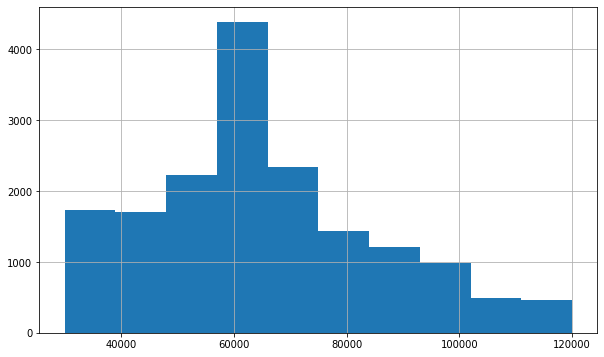

In [293]:
fig_dims = (10, 6)
fig, ax = plt.subplots(figsize=fig_dims)
profile.income.hist()

In [294]:
#Average income
profile.income.mean()

65404.99156829799

### What is the average age of Starbucks customers?

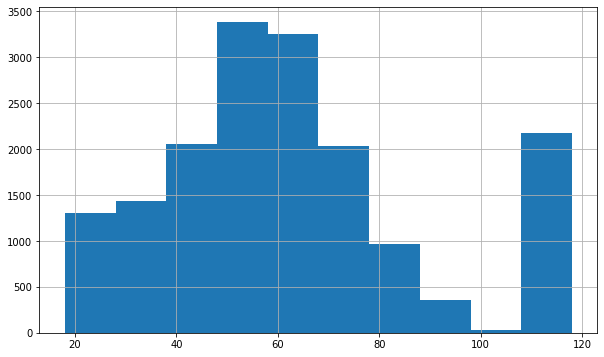

In [295]:
fig_dims = (10, 6)
fig, ax = plt.subplots(figsize=fig_dims)
profile.age.hist()

In [296]:
#Average age
profile.age.mean()

62.53141176470588

### What is the most common promotional offer?

In [297]:
transcript_offers=transcript[transcript.event=='offer completed']
transcript_offers

,person,event,time,amount,offer_id,reward
12658,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer completed,0,0.0,2906b810c7d4411798c6938adc9daaa5,2
12672,fe97aa22dd3e48c8b143116a8403dd52,offer completed,0,0.0,fafdcd668e3743c1bb461111dcafc2a4,2
12679,629fc02d56414d91bca360decdfa9288,offer completed,0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5
12692,676506bad68e4161b9bbaffeb039626b,offer completed,0,0.0,ae264e3637204a6fb9bb56bc8210ddfd,10
12697,8f7dd3b2afe14c078eb4f6e6fe4ba97d,offer completed,0,0.0,4d5c57ea9a6940dd891ad53e9dbe8da0,10
...,...,...,...,...,...,...
306475,0c027f5f34dd4b9eba0a25785c611273,offer completed,714,0.0,2298d6c36e964ae4a3e7e9706d1fb8c2,3
306497,a6f84f4e976f44508c358cc9aba6d2b3,offer completed,714,0.0,2298d6c36e964ae4a3e7e9706d1fb8c2,3
306506,b895c57e8cd047a8872ce02aa54759d6,offer completed,714,0.0,fafdcd668e3743c1bb461111dcafc2a4,2
306509,8431c16f8e1d440880db371a68f82dd0,offer completed,714,0.0,fafdcd668e3743c1bb461111dcafc2a4,2


In [298]:
portfolio[['id','offer_name']]

,id,offer_name
0,ae264e3637204a6fb9bb56bc8210ddfd,offer_1
1,4d5c57ea9a6940dd891ad53e9dbe8da0,offer_2
2,3f207df678b143eea3cee63160fa8bed,offer_3
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,offer_4
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,offer_5
5,2298d6c36e964ae4a3e7e9706d1fb8c2,offer_6
6,fafdcd668e3743c1bb461111dcafc2a4,offer_7
7,5a8bc65990b245e5a138643cd4eb9837,offer_8
8,f19421c1d4aa40978ebb69ca19b0e20d,offer_9
9,2906b810c7d4411798c6938adc9daaa5,offer_10


In [299]:
transcript_offers=transcript_offers.merge(portfolio[['id','offer_name']], left_on='offer_id',right_on='id',how='left').drop('id',axis=1)
transcript_offers

,person,event,time,amount,offer_id,reward,offer_name
0,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer completed,0,0.0,2906b810c7d4411798c6938adc9daaa5,2,offer_10
1,fe97aa22dd3e48c8b143116a8403dd52,offer completed,0,0.0,fafdcd668e3743c1bb461111dcafc2a4,2,offer_7
2,629fc02d56414d91bca360decdfa9288,offer completed,0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,offer_4
3,676506bad68e4161b9bbaffeb039626b,offer completed,0,0.0,ae264e3637204a6fb9bb56bc8210ddfd,10,offer_1
4,8f7dd3b2afe14c078eb4f6e6fe4ba97d,offer completed,0,0.0,4d5c57ea9a6940dd891ad53e9dbe8da0,10,offer_2
...,...,...,...,...,...,...,...
33574,0c027f5f34dd4b9eba0a25785c611273,offer completed,714,0.0,2298d6c36e964ae4a3e7e9706d1fb8c2,3,offer_6
33575,a6f84f4e976f44508c358cc9aba6d2b3,offer completed,714,0.0,2298d6c36e964ae4a3e7e9706d1fb8c2,3,offer_6
33576,b895c57e8cd047a8872ce02aa54759d6,offer completed,714,0.0,fafdcd668e3743c1bb461111dcafc2a4,2,offer_7
33577,8431c16f8e1d440880db371a68f82dd0,offer completed,714,0.0,fafdcd668e3743c1bb461111dcafc2a4,2,offer_7


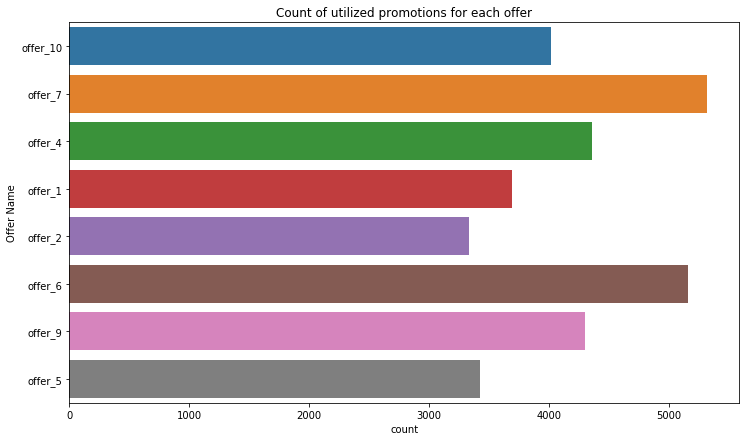

In [300]:
fig_dims = (12, 7)
fig, ax = plt.subplots(figsize=fig_dims)
sns.countplot(y=transcript_offers['offer_name'],ax=ax)
plt.title('Count of utilized promotions for each offer')
plt.ylabel('Offer Name')
plt.show();

#### From the chart we can say that the most popular offer is offer_7 followed by offer_6

### what is the most common offer type?

In [301]:
transcript_offer_types=transcript[transcript.event=='offer received']
transcript_offer_types

,person,event,time,amount,offer_id,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0
2,e2127556f4f64592b11af22de27a7932,offer received,0,0.0,2906b810c7d4411798c6938adc9daaa5,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,0.0,fafdcd668e3743c1bb461111dcafc2a4,0
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,0.0,4d5c57ea9a6940dd891ad53e9dbe8da0,0
...,...,...,...,...,...,...
257882,d087c473b4d247ccb0abfef59ba12b0e,offer received,576,0.0,ae264e3637204a6fb9bb56bc8210ddfd,0
257883,cb23b66c56f64b109d673d5e56574529,offer received,576,0.0,2906b810c7d4411798c6938adc9daaa5,0
257884,6d5f3a774f3d4714ab0c092238f3a1d7,offer received,576,0.0,2298d6c36e964ae4a3e7e9706d1fb8c2,0
257885,9dc1421481194dcd9400aec7c9ae6366,offer received,576,0.0,ae264e3637204a6fb9bb56bc8210ddfd,0


In [302]:
transcript_offer_types=transcript_offer_types.merge(portfolio[['id','offer_type']], left_on='offer_id',right_on='id',how='left').drop('id',axis=1)
transcript_offer_types

,person,event,time,amount,offer_id,reward,offer_type
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,bogo
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,discount
2,e2127556f4f64592b11af22de27a7932,offer received,0,0.0,2906b810c7d4411798c6938adc9daaa5,0,discount
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,0.0,fafdcd668e3743c1bb461111dcafc2a4,0,discount
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,0.0,4d5c57ea9a6940dd891ad53e9dbe8da0,0,bogo
...,...,...,...,...,...,...,...
76272,d087c473b4d247ccb0abfef59ba12b0e,offer received,576,0.0,ae264e3637204a6fb9bb56bc8210ddfd,0,bogo
76273,cb23b66c56f64b109d673d5e56574529,offer received,576,0.0,2906b810c7d4411798c6938adc9daaa5,0,discount
76274,6d5f3a774f3d4714ab0c092238f3a1d7,offer received,576,0.0,2298d6c36e964ae4a3e7e9706d1fb8c2,0,discount
76275,9dc1421481194dcd9400aec7c9ae6366,offer received,576,0.0,ae264e3637204a6fb9bb56bc8210ddfd,0,bogo


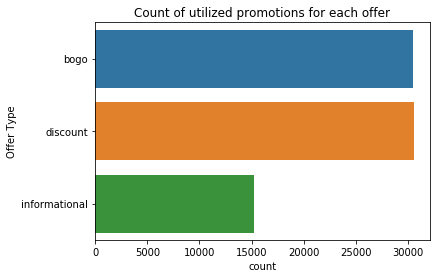

In [303]:
sns.countplot(y=transcript_offer_types['offer_type'])
plt.title('Count of utilized promotions for each offer')
plt.ylabel('Offer Type')
plt.show();

#### from the plot we can see that count of bogo and discount offer types are almost same and informational is half of these

### How are the success rates for different promotional offers?

The success rate of a promotional offer can be defined as the number of customers who completed or utilized the offer divided by the number of people who received the offer.

In [304]:
completed_offers=transcript[transcript['event']=='offer completed']
completed_offers_count=completed_offers.groupby('offer_id')['person'].count()
completed_offers_count

offer_id
0b1e1539f2cc45b7b9fa7c272da2e1d7    3420
2298d6c36e964ae4a3e7e9706d1fb8c2    5156
2906b810c7d4411798c6938adc9daaa5    4017
4d5c57ea9a6940dd891ad53e9dbe8da0    3331
9b98b8c7a33c4b65b9aebfe6a799e6d9    4354
ae264e3637204a6fb9bb56bc8210ddfd    3688
f19421c1d4aa40978ebb69ca19b0e20d    4296
fafdcd668e3743c1bb461111dcafc2a4    5317
Name: person, dtype: int64

In [305]:
total_offers=transcript[transcript['event']=='offer received']
total_offers_count=total_offers.groupby('offer_id')['person'].count()
total_offers_count

offer_id
0b1e1539f2cc45b7b9fa7c272da2e1d7    7668
2298d6c36e964ae4a3e7e9706d1fb8c2    7646
2906b810c7d4411798c6938adc9daaa5    7632
3f207df678b143eea3cee63160fa8bed    7617
4d5c57ea9a6940dd891ad53e9dbe8da0    7593
5a8bc65990b245e5a138643cd4eb9837    7618
9b98b8c7a33c4b65b9aebfe6a799e6d9    7677
ae264e3637204a6fb9bb56bc8210ddfd    7658
f19421c1d4aa40978ebb69ca19b0e20d    7571
fafdcd668e3743c1bb461111dcafc2a4    7597
Name: person, dtype: int64

In [306]:
success_rates=completed_offers_count/total_offers_count*100
success_rates=success_rates.reset_index()
success_rates

,offer_id,person
0,0b1e1539f2cc45b7b9fa7c272da2e1d7,44.600939
1,2298d6c36e964ae4a3e7e9706d1fb8c2,67.433952
2,2906b810c7d4411798c6938adc9daaa5,52.633648
3,3f207df678b143eea3cee63160fa8bed,NaN
4,4d5c57ea9a6940dd891ad53e9dbe8da0,43.869353
5,5a8bc65990b245e5a138643cd4eb9837,NaN
6,9b98b8c7a33c4b65b9aebfe6a799e6d9,56.714863
7,ae264e3637204a6fb9bb56bc8210ddfd,48.158788
8,f19421c1d4aa40978ebb69ca19b0e20d,56.742835
9,fafdcd668e3743c1bb461111dcafc2a4,69.988153


In [307]:
success_rates=success_rates.merge(portfolio[['id','offer_name']], left_on='offer_id', right_on='id', how='left').drop('id',axis=1)
success_rates.columns=['offer_id','success percentage','offer name']
success_rates=success_rates.sort_values('success percentage').dropna()
success_rates

,offer_id,success percentage,offer name
4,4d5c57ea9a6940dd891ad53e9dbe8da0,43.869353,offer_2
0,0b1e1539f2cc45b7b9fa7c272da2e1d7,44.600939,offer_5
7,ae264e3637204a6fb9bb56bc8210ddfd,48.158788,offer_1
2,2906b810c7d4411798c6938adc9daaa5,52.633648,offer_10
6,9b98b8c7a33c4b65b9aebfe6a799e6d9,56.714863,offer_4
8,f19421c1d4aa40978ebb69ca19b0e20d,56.742835,offer_9
1,2298d6c36e964ae4a3e7e9706d1fb8c2,67.433952,offer_6
9,fafdcd668e3743c1bb461111dcafc2a4,69.988153,offer_7


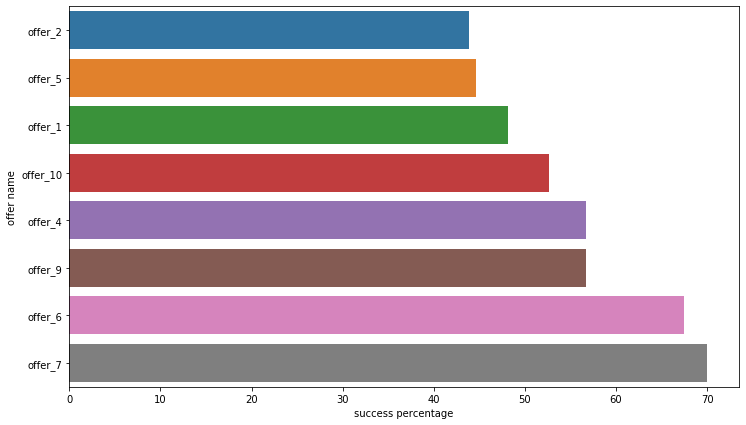

In [308]:
fig_dims = (12, 7)
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(x='success percentage', y='offer name', data=success_rates,ax=ax)

#### From the plot we can say offer_7 is the most successful offer

### What are the most successful promotional offers among different age groups?

In [309]:
completed_offers_by_age=completed_offers.merge(profile[['id','age']], left_on='person', right_on='id', how='left').drop('id',axis=1)
completed_offers_by_age

,person,event,time,amount,offer_id,reward,age
0,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer completed,0,0.0,2906b810c7d4411798c6938adc9daaa5,2,42
1,fe97aa22dd3e48c8b143116a8403dd52,offer completed,0,0.0,fafdcd668e3743c1bb461111dcafc2a4,2,39
2,629fc02d56414d91bca360decdfa9288,offer completed,0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,52
3,676506bad68e4161b9bbaffeb039626b,offer completed,0,0.0,ae264e3637204a6fb9bb56bc8210ddfd,10,37
4,8f7dd3b2afe14c078eb4f6e6fe4ba97d,offer completed,0,0.0,4d5c57ea9a6940dd891ad53e9dbe8da0,10,48
...,...,...,...,...,...,...,...
33574,0c027f5f34dd4b9eba0a25785c611273,offer completed,714,0.0,2298d6c36e964ae4a3e7e9706d1fb8c2,3,56
33575,a6f84f4e976f44508c358cc9aba6d2b3,offer completed,714,0.0,2298d6c36e964ae4a3e7e9706d1fb8c2,3,118
33576,b895c57e8cd047a8872ce02aa54759d6,offer completed,714,0.0,fafdcd668e3743c1bb461111dcafc2a4,2,118
33577,8431c16f8e1d440880db371a68f82dd0,offer completed,714,0.0,fafdcd668e3743c1bb461111dcafc2a4,2,39


In [310]:
# categorizing age into 3 categories (teens<=20 , 20< adults >40 , elders >=40)

def age_category(age):
    if(age <=20):
        return 'Teens'
    if(age>=40):
        return 'Elders'
    return 'Adults'

In [311]:
completed_offers_by_age['age_category']=[age_category(age) for age in completed_offers_by_age.age]
completed_offers_by_age

,person,event,time,amount,offer_id,reward,age,age_category
0,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer completed,0,0.0,2906b810c7d4411798c6938adc9daaa5,2,42,Elders
1,fe97aa22dd3e48c8b143116a8403dd52,offer completed,0,0.0,fafdcd668e3743c1bb461111dcafc2a4,2,39,Adults
2,629fc02d56414d91bca360decdfa9288,offer completed,0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,52,Elders
3,676506bad68e4161b9bbaffeb039626b,offer completed,0,0.0,ae264e3637204a6fb9bb56bc8210ddfd,10,37,Adults
4,8f7dd3b2afe14c078eb4f6e6fe4ba97d,offer completed,0,0.0,4d5c57ea9a6940dd891ad53e9dbe8da0,10,48,Elders
...,...,...,...,...,...,...,...,...
33574,0c027f5f34dd4b9eba0a25785c611273,offer completed,714,0.0,2298d6c36e964ae4a3e7e9706d1fb8c2,3,56,Elders
33575,a6f84f4e976f44508c358cc9aba6d2b3,offer completed,714,0.0,2298d6c36e964ae4a3e7e9706d1fb8c2,3,118,Elders
33576,b895c57e8cd047a8872ce02aa54759d6,offer completed,714,0.0,fafdcd668e3743c1bb461111dcafc2a4,2,118,Elders
33577,8431c16f8e1d440880db371a68f82dd0,offer completed,714,0.0,fafdcd668e3743c1bb461111dcafc2a4,2,39,Adults


In [312]:
completed_offers_by_age_count=completed_offers_by_age.groupby(['offer_id','age_category'])['person'].count()
completed_offers_by_age_count

offer_id                          age_category
0b1e1539f2cc45b7b9fa7c272da2e1d7  Adults           476
                                  Elders          2899
                                  Teens             45
2298d6c36e964ae4a3e7e9706d1fb8c2  Adults           899
                                  Elders          4152
                                  Teens            105
2906b810c7d4411798c6938adc9daaa5  Adults           604
                                  Elders          3350
                                  Teens             63
4d5c57ea9a6940dd891ad53e9dbe8da0  Adults           444
                                  Elders          2843
                                  Teens             44
9b98b8c7a33c4b65b9aebfe6a799e6d9  Adults           706
                                  Elders          3581
                                  Teens             67
ae264e3637204a6fb9bb56bc8210ddfd  Adults           489
                                  Elders          3145
                  

In [313]:
total_offers_by_age=total_offers.merge(profile[['id','age']], left_on='person', right_on='id', how='left').drop('id',axis=1)
total_offers_by_age

,person,event,time,amount,offer_id,reward,age
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,75
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,118
2,e2127556f4f64592b11af22de27a7932,offer received,0,0.0,2906b810c7d4411798c6938adc9daaa5,0,68
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,0.0,fafdcd668e3743c1bb461111dcafc2a4,0,118
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,0.0,4d5c57ea9a6940dd891ad53e9dbe8da0,0,118
...,...,...,...,...,...,...,...
76272,d087c473b4d247ccb0abfef59ba12b0e,offer received,576,0.0,ae264e3637204a6fb9bb56bc8210ddfd,0,56
76273,cb23b66c56f64b109d673d5e56574529,offer received,576,0.0,2906b810c7d4411798c6938adc9daaa5,0,60
76274,6d5f3a774f3d4714ab0c092238f3a1d7,offer received,576,0.0,2298d6c36e964ae4a3e7e9706d1fb8c2,0,45
76275,9dc1421481194dcd9400aec7c9ae6366,offer received,576,0.0,ae264e3637204a6fb9bb56bc8210ddfd,0,83


In [314]:
total_offers_by_age['age_category']=[age_category(age) for age in total_offers_by_age.age]
total_offers_by_age

,person,event,time,amount,offer_id,reward,age,age_category
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,75,Elders
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,118,Elders
2,e2127556f4f64592b11af22de27a7932,offer received,0,0.0,2906b810c7d4411798c6938adc9daaa5,0,68,Elders
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,0.0,fafdcd668e3743c1bb461111dcafc2a4,0,118,Elders
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,0.0,4d5c57ea9a6940dd891ad53e9dbe8da0,0,118,Elders
...,...,...,...,...,...,...,...,...
76272,d087c473b4d247ccb0abfef59ba12b0e,offer received,576,0.0,ae264e3637204a6fb9bb56bc8210ddfd,0,56,Elders
76273,cb23b66c56f64b109d673d5e56574529,offer received,576,0.0,2906b810c7d4411798c6938adc9daaa5,0,60,Elders
76274,6d5f3a774f3d4714ab0c092238f3a1d7,offer received,576,0.0,2298d6c36e964ae4a3e7e9706d1fb8c2,0,45,Elders
76275,9dc1421481194dcd9400aec7c9ae6366,offer received,576,0.0,ae264e3637204a6fb9bb56bc8210ddfd,0,83,Elders


In [315]:
total_offers_by_age_count=total_offers_by_age.groupby(['offer_id','age_category'])['person'].count()
total_offers_by_age_count

offer_id                          age_category
0b1e1539f2cc45b7b9fa7c272da2e1d7  Adults          1287
                                  Elders          6251
                                  Teens            130
2298d6c36e964ae4a3e7e9706d1fb8c2  Adults          1291
                                  Elders          6199
                                  Teens            156
2906b810c7d4411798c6938adc9daaa5  Adults          1277
                                  Elders          6203
                                  Teens            152
3f207df678b143eea3cee63160fa8bed  Adults          1244
                                  Elders          6225
                                  Teens            148
4d5c57ea9a6940dd891ad53e9dbe8da0  Adults          1235
                                  Elders          6192
                                  Teens            166
5a8bc65990b245e5a138643cd4eb9837  Adults          1202
                                  Elders          6256
                  

In [316]:
success_rate_by_age=completed_offers_by_age_count/total_offers_by_age_count*100
success_rate_by_age=success_rate_by_age.reset_index().dropna()
success_rate_by_age

,offer_id,age_category,person
0,0b1e1539f2cc45b7b9fa7c272da2e1d7,Adults,36.985237
1,0b1e1539f2cc45b7b9fa7c272da2e1d7,Elders,46.376580
2,0b1e1539f2cc45b7b9fa7c272da2e1d7,Teens,34.615385
3,2298d6c36e964ae4a3e7e9706d1fb8c2,Adults,69.635941
4,2298d6c36e964ae4a3e7e9706d1fb8c2,Elders,66.978545
5,2298d6c36e964ae4a3e7e9706d1fb8c2,Teens,67.307692
6,2906b810c7d4411798c6938adc9daaa5,Adults,47.298356
7,2906b810c7d4411798c6938adc9daaa5,Elders,54.006126
8,2906b810c7d4411798c6938adc9daaa5,Teens,41.447368
12,4d5c57ea9a6940dd891ad53e9dbe8da0,Adults,35.951417


In [317]:
success_rate_by_age=success_rate_by_age.merge(portfolio[['id','offer_name']], left_on='offer_id', right_on='id', how='left').drop('id',axis=1)
success_rate_by_age.columns=['offer_id','age_category','success percentage','offer name']
success_rate_by_age=success_rate_by_age.sort_values('success percentage').dropna()
success_rate_by_age

,offer_id,age_category,success percentage,offer name
11,4d5c57ea9a6940dd891ad53e9dbe8da0,Teens,26.506024,offer_2
17,ae264e3637204a6fb9bb56bc8210ddfd,Teens,34.615385,offer_1
2,0b1e1539f2cc45b7b9fa7c272da2e1d7,Teens,34.615385,offer_5
9,4d5c57ea9a6940dd891ad53e9dbe8da0,Adults,35.951417,offer_2
0,0b1e1539f2cc45b7b9fa7c272da2e1d7,Adults,36.985237,offer_5
15,ae264e3637204a6fb9bb56bc8210ddfd,Adults,39.467312,offer_1
8,2906b810c7d4411798c6938adc9daaa5,Teens,41.447368,offer_10
14,9b98b8c7a33c4b65b9aebfe6a799e6d9,Teens,45.578231,offer_4
10,4d5c57ea9a6940dd891ad53e9dbe8da0,Elders,45.914083,offer_2
1,0b1e1539f2cc45b7b9fa7c272da2e1d7,Elders,46.376580,offer_5


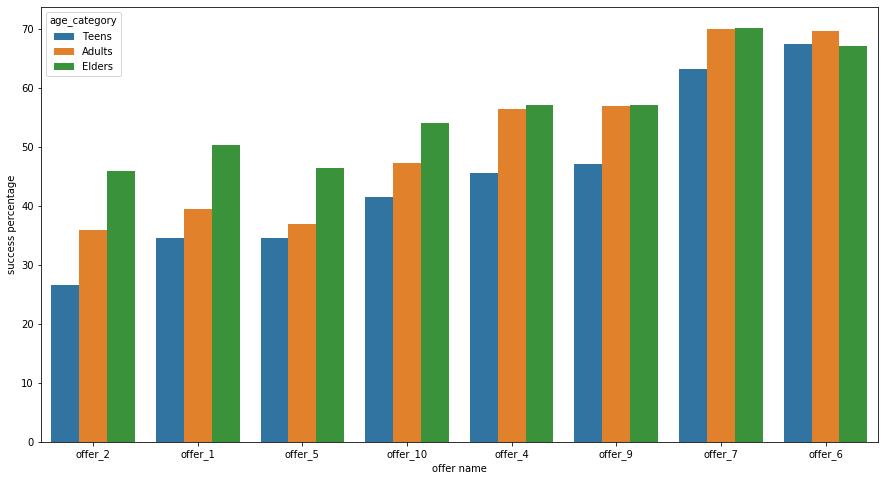

In [318]:
fig_dims = (15, 8)
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(y='success percentage', x='offer name', data=success_rate_by_age,hue='age_category',ax=ax)

##### From the plot,most successful offer among 

teens  = offer_6

adults = offer_6, offer_7

elders = offer_7 

### Who are the top 20 Starbuck loyal Customers?

In [319]:
#find each customers' total purchase amount
customers=transcript[transcript['event']=='transaction'].groupby('person').sum()['amount'].reset_index().sort_values('amount',ascending=False)
customers.columns=['person','Total Amount($)']
customers.head()

,person,Total Amount($)
3929,3c8d541112a74af99e88abbd0692f00e,1608.69
15693,f1d65ae63f174b8f80fa063adcaa63b7,1365.66
11422,ae6f43089b674728a50b8727252d3305,1327.74
6366,626df8678e2a4953b9098246418c9cfa,1321.42
7492,73afdeca19e349b98f09e928644610f8,1319.97


In [320]:
#find total transactions of each customer
customers=customers.merge(transcript[transcript['event']=='transaction'].groupby('person').count()['event'].reset_index(),on='person')
customers.columns=['person','Total Amount($)','Total Transactions']
customers.head()

,person,Total Amount($),Total Transactions
0,3c8d541112a74af99e88abbd0692f00e,1608.69,8
1,f1d65ae63f174b8f80fa063adcaa63b7,1365.66,13
2,ae6f43089b674728a50b8727252d3305,1327.74,16
3,626df8678e2a4953b9098246418c9cfa,1321.42,13
4,73afdeca19e349b98f09e928644610f8,1319.97,10


In [321]:
# find number of offers uttilized by each customer
customers=customers.merge(transcript[transcript['event']=='offer completed'].groupby('person')['offer_id'].count().reset_index(),on='person')
customers.columns=['Person','Total Amount($)','Total Transactions','Offers Utilized']
customers.head()

,Person,Total Amount($),Total Transactions,Offers Utilized
0,3c8d541112a74af99e88abbd0692f00e,1608.69,8,5
1,f1d65ae63f174b8f80fa063adcaa63b7,1365.66,13,6
2,ae6f43089b674728a50b8727252d3305,1327.74,16,3
3,626df8678e2a4953b9098246418c9cfa,1321.42,13,4
4,73afdeca19e349b98f09e928644610f8,1319.97,10,5


In [322]:
#find top 20 loyal customers
loyal_customers_20=customers.head(20)
loyal_customers_20

,Person,Total Amount($),Total Transactions,Offers Utilized
0,3c8d541112a74af99e88abbd0692f00e,1608.69,8,5
1,f1d65ae63f174b8f80fa063adcaa63b7,1365.66,13,6
2,ae6f43089b674728a50b8727252d3305,1327.74,16,3
3,626df8678e2a4953b9098246418c9cfa,1321.42,13,4
4,73afdeca19e349b98f09e928644610f8,1319.97,10,5
5,52959f19113e4241a8cb3bef486c6412,1292.86,12,5
6,ad1f0a409ae642bc9a43f31f56c130fc,1258.19,5,3
7,d240308de0ee4cf8bb6072816268582b,1251.99,14,5
8,946fc0d3ecc4492aa4cc06cf6b1492c3,1232.40,17,4
9,6406abad8e2c4b8584e4f68003de148d,1211.76,12,3


### Data Modeling

In [323]:
#Renaming columns
profile.columns=['Gender','Age','Person','Registered Date','Income']
profile.head()

,Gender,Age,Person,Registered Date,Income
0,M,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,65404.991568
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.000000
2,M,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,65404.991568
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.000000
4,M,118,a03223e636434f42ac4c3df47e8bac43,20170804,65404.991568


In [324]:
#Gathering required features for modeling
customers=customers.merge(profile, on='Person')
customers

,Person,Total Amount($),Total Transactions,Offers Utilized,Gender,Age,Registered Date,Income
0,3c8d541112a74af99e88abbd0692f00e,1608.69,8,5,M,77,20170926,97000.000000
1,f1d65ae63f174b8f80fa063adcaa63b7,1365.66,13,6,M,32,20180619,64000.000000
2,ae6f43089b674728a50b8727252d3305,1327.74,16,3,F,36,20170521,71000.000000
3,626df8678e2a4953b9098246418c9cfa,1321.42,13,4,M,53,20150825,103000.000000
4,73afdeca19e349b98f09e928644610f8,1319.97,10,5,M,50,20160512,86000.000000
...,...,...,...,...,...,...,...,...
12769,a67ec25ff5d347848636367c636362ed,6.14,1,1,M,118,20180314,65404.991568
12770,61fe324417804f37a5c60a911c15f2f1,5.54,2,1,M,45,20180414,33000.000000
12771,bae1ea0e87214a9fbc58d71c7062448c,5.54,2,1,M,118,20170923,65404.991568
12772,3d3e9cf3fd384c99890a5711ab998816,5.46,1,1,M,118,20180321,65404.991568


#### Lets predict if a customer responds to a promotional offer with offer id='4d5c57ea9a6940dd891ad53e9dbe8da0' . 

In [325]:
#Find the output label for the model
# 1- customer responded to offer, 0 - customer didn't respond
customers.set_index('Person',inplace=True)
customers['offer_response']=np.zeros(customers.shape[0]).astype(int)


responded_customers=np.array(transcript[(transcript.offer_id=='4d5c57ea9a6940dd891ad53e9dbe8da0') & (transcript.event=='offer completed')].person)

for customer in responded_customers:
    customers.loc[customer,'offer_response']=1
    
customers    

,Total Amount($),Total Transactions,Offers Utilized,Gender,Age,Registered Date,Income,offer_response
Person,,,,,,,,
3c8d541112a74af99e88abbd0692f00e,1608.69,8,5,M,77,20170926,97000.000000,0
f1d65ae63f174b8f80fa063adcaa63b7,1365.66,13,6,M,32,20180619,64000.000000,0
ae6f43089b674728a50b8727252d3305,1327.74,16,3,F,36,20170521,71000.000000,0
626df8678e2a4953b9098246418c9cfa,1321.42,13,4,M,53,20150825,103000.000000,0
73afdeca19e349b98f09e928644610f8,1319.97,10,5,M,50,20160512,86000.000000,0
...,...,...,...,...,...,...,...,...
a67ec25ff5d347848636367c636362ed,6.14,1,1,M,118,20180314,65404.991568,0
61fe324417804f37a5c60a911c15f2f1,5.54,2,1,M,45,20180414,33000.000000,0
bae1ea0e87214a9fbc58d71c7062448c,5.54,2,1,M,118,20170923,65404.991568,0


In [326]:
customers=pd.get_dummies(customers,drop_first=True)
customers.head()

,Total Amount($),Total Transactions,Offers Utilized,Age,Registered Date,Income,offer_response,Gender_M,Gender_O
Person,,,,,,,,,
3c8d541112a74af99e88abbd0692f00e,1608.69,8,5,77,20170926,97000.0,0,1,0
f1d65ae63f174b8f80fa063adcaa63b7,1365.66,13,6,32,20180619,64000.0,0,1,0
ae6f43089b674728a50b8727252d3305,1327.74,16,3,36,20170521,71000.0,0,0,0
626df8678e2a4953b9098246418c9cfa,1321.42,13,4,53,20150825,103000.0,0,1,0
73afdeca19e349b98f09e928644610f8,1319.97,10,5,50,20160512,86000.0,0,1,0


In [327]:
features=customers[['Total Amount($)','Total Transactions','Age','Registered Date','Income','Offers Utilized','Gender_M','Gender_O']]
features.head()

,Total Amount($),Total Transactions,Age,Registered Date,Income,Offers Utilized,Gender_M,Gender_O
Person,,,,,,,,
3c8d541112a74af99e88abbd0692f00e,1608.69,8,77,20170926,97000.0,5,1,0
f1d65ae63f174b8f80fa063adcaa63b7,1365.66,13,32,20180619,64000.0,6,1,0
ae6f43089b674728a50b8727252d3305,1327.74,16,36,20170521,71000.0,3,0,0
626df8678e2a4953b9098246418c9cfa,1321.42,13,53,20150825,103000.0,4,1,0
73afdeca19e349b98f09e928644610f8,1319.97,10,50,20160512,86000.0,5,1,0


In [328]:
target=customers['offer_response']

In [329]:
xtrain, xtest, ytrain, ytest = train_test_split(features,target,test_size=0.3,random_state=40)

In [330]:
from sklearn.naive_bayes import GaussianNB


### Gausian Naive Bias

In [331]:
gnb = GaussianNB()
gnb.fit(xtrain,ytrain)

GaussianNB(priors=None, var_smoothing=1e-09)

In [332]:
# train set score
gaussian.score(xtrain,ytrain)

0.7503634940163293

In [333]:
# test set score
gaussian.score(xtest,ytest)

0.7591964518653797

### Model Improvements
With the Gausian Naive Bias model we got an accuracy of around 75 % on both the training set and the testing set.

Let's try to improve the accuracy by using other algorithms and by tuning those with hyper parameters for the best possible model

### Decision Tree Classifier

##### First lets find the model accuracy on the base instance of this algorithm and then tune the model by changing its hyper parameters

In [481]:
dtc0=DecisionTreeClassifier()
dtc0.fit(xtrain, ytrain)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [482]:
#train set score 
dtc0.score(xtrain, ytrain)

1.0

In [483]:
#test set score
dtc0.score(xtest, ytest)

0.6897991129663449

#### here if we notice, score on training set is 1.0 and on testing set is only 0.689. This means our model is overfitted. Lets improve this model by tuning the hyper parameters

In [356]:
dtc = DecisionTreeClassifier()

tree_parameters = {'criterion':['gini','entropy'],
                   'max_depth':[3,4,5,6,7,8,9,10,11,12,15,20],
                    'min_samples_split':[2,3,4,5,6],
                     'min_samples_leaf':[1,2,3]}

grid_dtc = GridSearchCV(estimator=dtc, param_grid=tree_parameters,cv=5)
grid_dtc_result = grid_dtc.fit(xtrain, ytrain)
grid_dtc_result

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 2

In [357]:
grid_dtc.best_params_

{'criterion': 'entropy',
 'max_depth': 4,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

In [358]:
#train set score
grid_dtc_result.score(xtrain, ytrain)

0.7740744883122693

In [359]:
#test_set_score
grid_dtc_result.score(xtest,ytest)

0.7782415862248891

#### Now the model score on testing and training set is almost the same. By tuning we improved the model performance from the base instance
#### Also now the model score is nearly 2.5 percent more than that of the Gaussian naive bias model on both training and the test set.
##### The best model parameters now are
##### {'criterion': 'entropy',
##### 'max_depth': 4,
##### 'min_samples_leaf': 1,
##### 'min_samples_split': 2}

### K Neighbors Classifier

##### For this also lets find the model accuracy on the base instance of this algorithm and then tune the model by changing its hyper parameters¶

In [485]:
kn0=KNeighborsClassifier()
kn0.fit(xtrain, ytrain)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [486]:
#train set score 
kn0.score(xtrain, ytrain)

0.804607985683928

In [487]:
#test set score 
kn0.score(xtest, ytest)

0.7443255935298722

#### Even in this case, there is large difference in model scores between the training and testing set. It seems there is a overfitting. Lets try to increase the model prediction performance

In [461]:
kn=KNeighborsClassifier()
tree_parameters = {'weights':['uniform','distance'],
                'algorithm':['auto', 'ball_tree'],
                'n_neighbors':[3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
                 }

In [462]:
grid_kn = GridSearchCV(estimator=kn, param_grid=tree_parameters,cv=5)
grid_kn_result = grid_kn.fit(xtrain, ytrain)
grid_kn_result

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=None,
             param_grid={'algorithm': ['auto', 'ball_tree'],
                         'n_neighbors': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                         14, 15, 16, 17, 18, 19, 20],
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [463]:
grid_kn.best_params_

{'algorithm': 'auto', 'n_neighbors': 16, 'weights': 'uniform'}

In [464]:
#train set score
grid_kn_result.score(xtrain, ytrain)

0.7739626439995526

In [466]:
#testt set score
grid_kn_result.score(xtest, ytest)

0.7751108792068876

#### Now the model score on testing and training set is almost same. By tuning we improved the model performance from the base instance
#### Also now the model score is nearly 2.5 percent more than that of the Gaussian naive bias model on both training and the test set.
##### The best model parameters now are
##### {'algorithm': 'auto', 'n_neighbors': 16, 'weights': 'uniform'}


### Random Forest Classifier

##### For this also lets find the model accuracy on the base instance of this algorithm and then tune the model by changing its hyper parameters¶

In [489]:
rf0=RandomForestClassifier()
rf0.fit(xtrain, ytrain)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [490]:
rf0.score(xtrain, ytrain)

0.9804272452745778

In [491]:
rf0.score(xtest, ytest)

0.7591964518653797

#### Even in this case, there is large difference in model scores between the training and testing set. It seems there is a overfitting. Lets try to increase the model prediction performance by tuning the parameters

In [488]:
rf=RandomForestClassifier()

parameters = {'criterion':['gini','entropy'],
              'n_estimators':[11,12,13,15,16,17,18,19,20,21,22,23,24,25,30],
              'max_depth':[4,5,6,7,8,9,10,11,12,13,14,15,16,20]                 
                 }

In [451]:
grid_rf = GridSearchCV(estimator=rf, param_grid=parameters,cv=5)
grid_rf_result = grid_rf.fit(xtrain, ytrain)
grid_rf_result

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [452]:
grid_rf.best_params_

{'criterion': 'gini', 'max_depth': 8, 'n_estimators': 23}

In [453]:
#train set score
grid_rf_result.score(xtrain, ytrain)

0.7836930992059054

In [455]:
#test set score
grid_rf_result.score(xtest, ytest)

0.7785024784763892

#### Now the model score on testing and training set is almost same. By tuning we improved the model performance from the base instance
#### Also now the model score is nearly 3 percent more than that of the Gaussian naive bias model on both training and the test set.
##### The best model parameters now are
##### {'criterion': 'gini', 'max_depth': 8, 'n_estimators': 23}


### Model Results

In [469]:
models=[gaussian,grid_dtc_result,grid_kn_result,grid_rf_result]
training_accuracy = [m.score(xtrain, ytrain)*100 for m in models]
testing_accuracy= [m.score(xtest, ytest)*100 for m in models]
columns=['GaussianNB','DecisionTreeClassifier','KNeighborsClassifier','RandomForestClassifier']
index=['training_accuracy','testing_accuracy']

model_results=pd.DataFrame([training_accuracy,testing_accuracy],index=index,columns=columns)
model_results

,GaussianNB,DecisionTreeClassifier,KNeighborsClassifier,RandomForestClassifier
training_accuracy,75.036349,77.407449,77.396264,78.369310
testing_accuracy,75.919645,77.824159,77.511088,77.850248


### Among all the four models, accuracy of RandomForestClassifier model is the highest on both training and testing sets

### Conclusion and Recomendations
1. From the Analysis, we observed that most common promotional offer and also the promitional offer with highest success rate is offer_7( offer_id = fafdcd668e3743c1bb461111dcafc2a4 ) and followed by this is offer_6 (offer_id = 2298d6c36e964ae4a3e7e9706d1fb8c2). So company should focus on rolling out more of these kind of offers.

2. If we keenly observe the most successful offers among different age groups, then among teens, the most successful offer is offer_6. So this should be the top priority offer to be rolled out among teens. For adults, it is offer_6, offer_7. And for elders it is offer_7 from our analysis.

3. We have found out the top 20 loyal customers and also these customers are the high spending customers. So company can focus on introducing a loyalty scheme for these kind of customers to attract more sales from them. A new scheme for these kind of customers can be rolled out like if a custotmer spends 100$, they can get 20 percent discount in their next order. Or yet another scheme like giving some freebies for large orders.

4. Finally four supervised ml models are built to predict if a customer can respond to a promotional offer. Among all the four models, the best model with highest score is RandomForestClassifier model with the training accuracy and testing accuracy nearly equal to 78 % and the model parameters are {'criterion': 'gini', 'max_depth': 8, 'n_estimators': 23}
5. With the help of this predictive model, now maketing team can determine the right set of promotional offers to each of the customers.